# Efficient Object Detection with YOLOV8 and KerasCV

[Keras tutorial](https://keras.io/examples/vision/yolov8/)

## Import nessessary libraries

In [68]:
import random
import os
from glob import glob
from pathlib import Path

import torch
from IPython.display import Image  # for displaying images
from PIL import Image

random.seed(42)

import logging

logging.getLogger().setLevel(logging.CRITICAL)
# !pip install pylabel > /dev/null

#!pip install pylabel

from pylabel import *
from pylabel import importer


Example annotation in yolo txt format: class_id, x_center, y_center, width, height

In [69]:
# An example annotation
!cat ../data/split_yolo/labels/test/american_pit_bull_terrier_0012.txt

8 0.5001 0.5029 0.9627 0.9923


In [70]:
# An example YAML file
!cat ../data/split_yolo/dataset.yaml

names:
  - dogue_de_bordeaux
  - staffordshire_bullterrier
  - dogo_argentino
  - other_dog_breed
  - cau_ovcharka
  - person
  - human_face
  - am_pit_bull_terrier
  - fila_brasileiro
  - bull_terrier
  - kangal
  - neapolitan_mastiff
  - rottweiler
  - bull_mastiff
  - mastin_espanol
  - tosa_inu
  - am_staffordshire_terrier
  - mastiff
nc: 18
path: /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/
test: /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/images/test
train: /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/images/train
val: /Users/tillmeineke/ML/ML_Zoomcamp2024_hw/helloListenDog/data/split_yolo/images/val


## Getting the Image and annotation folder

Dataset has one folder ("../data/renamed_dub_removed")

In [ ]:
# Define path to stored dataset
img_str = "images"
label_str = "labels"

root_dir = Path("../data/split_yolo/")
# Create dataset dir if not exists
# dataset_dir.mkdir(parents=True, exist_ok=True)


img_dir = root_dir / img_str / "train"
labels_dir = root_dir / label_str / "train"

pd.Series(
    {
        "Dataset Directory": root_dir,
        "Image Directory": img_dir,
        "Labels Directory": labels_dir,
    }
).to_frame().style.hide(axis="columns")


### Get Image File Paths

In [34]:
def get_img_files(
    img_dir: Path,  # The directory to search for image files
    img_fmts=["jpg", "jpeg", "png"],  # The list of image formats to search for
):
    """
    Get all the image files in the given directory.

    Returns:
    img_paths (list): A list of pathlib.Path objects representing the image files
    """
    img_paths = []

    # Use the glob module to search for image files with specified formats
    for fmt in img_fmts:
        img_paths.extend(sorted(glob(f"{img_dir}/*.{fmt}")))
    # Convert the file paths to pathlib.Path objects
    img_paths = [Path(path) for path in img_paths]

    return img_paths

Each image file has a unique name that we can use to locate the corresponding annotation data. We can make a dictionary that maps image names to file paths. The dictionary will allow us to retrieve the file path for a given image more efficiently.

In [35]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem: file  # Create a dictionary that maps file names to file paths
    for file in get_img_files(
        img_dir
    )  # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient="index").head().style.hide(axis="columns")

Number of Images: 1089


In [30]:
img_dir.glob("*")

<generator object Path.glob at 0x116248e10>

In [37]:
annotation_files = list(sorted(labels_dir.glob("*")))
annotation_files[:5]

[PosixPath('../data/split_yolo/labels/train/american_pit_bull_terrier_0001.txt'),
 PosixPath('../data/split_yolo/labels/train/american_pit_bull_terrier_0002.txt'),
 PosixPath('../data/split_yolo/labels/train/american_pit_bull_terrier_0003.txt'),
 PosixPath('../data/split_yolo/labels/train/american_pit_bull_terrier_0004.txt'),
 PosixPath('../data/split_yolo/labels/train/american_pit_bull_terrier_0005.txt')]

In [ ]:
dataset_train = importer.ImportYoloV5(
    path="../data/split_yolo/labels/train",
    path_to_images="../../images/train",
    img_ext="jpg",
    cat_names=[
        "__background__",
        "dogue_de_bordeaux",
        "staffordshire_bullterrier",
        "dogo_argentino",
        "other_dog_breed",
        "cau_ovcharka",
        "person",
        "human_face",
        "am_pit_bull_terrier",
        "fila_brasileiro",
        "bull_terrier",
        "kangal",
        "neapolitan_mastiff",
        "rottweiler",
        "bull_mastiff",
        "mastin_espanol",
        "tosa_inu",
        "am_staffordshire_terrier",
        "mastiff",
    ],
)

In [64]:
dataset_train.df.sort_values(by="img_id").head()

img_folder                 img_filename img_path  img_id  \
id                                                                     
0   ../../images/train  neapolitan_mastiff_0030.jpg                0   
1   ../../images/train  neapolitan_mastiff_0030.jpg                0   
2   ../../images/train          rottweiler_0066.jpg                1   
3   ../../images/train          rottweiler_0072.jpg                2   
4   ../../images/train  neapolitan_mastiff_0024.jpg                3   

    img_width  img_height  img_depth ann_segmented  ann_bbox_xmin  \
id                                                                  
0         844        1500          3                       1.7724   
1         844        1500          3                      -0.0422   
2         360         270          3                      -0.0180   
3         500         333          3                     119.0250   
4        1600        1216          3                      -0.0800   

    ann_bbox_ymin  ...  ann_iscrowd  ann_keypoints  ann_pose  ann_truncated  \
id                 ...                                                        
0         64.5750  ...                                                        
1        306.0000  ...                                                        
2         -0.0135  ...                                                        
3          0.0000  ...                                                        
4         85.9712  ...                                                        

    ann_difficult cat_id            cat_name cat_supercategory split annotated  
id                                                                              
0                     12  neapolitan_mastiff                                 1  
1                      6              person                                 1  
2                     13          rottweiler                                 1  
3                     13          rottweiler                                 1  
4                     12  neapolitan_mastiff                                 1  

[5 rows x 26 columns]

In [65]:
labels_map = {}
for i, label in enumerate(dataset_train.analyze.classes):
    labels_map[i] = label

labels_map

{0: 'dogue_de_bordeaux',
 1: 'staffordshire_bullterrier',
 2: 'dogo_argentino',
 3: 'other_dog_breed',
 4: 'cau_ovcharka',
 5: 'person',
 6: 'human_face',
 7: 'am_pit_bull_terrier',
 8: 'fila_brasileiro',
 9: 'bull_terrier',
 10: 'kangal',
 11: 'neapolitan_mastiff',
 12: 'rottweiler',
 13: 'bull_mastiff',
 14: 'mastin_espanol',
 15: 'tosa_inu',
 16: 'am_staffordshire_terrier',
 17: 'mastiff'}

In [66]:
print(f"Number of images: {dataset_train.analyze.num_images}")
print(f"Number of classes: {dataset_train.analyze.num_classes}")
# print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset_train.analyze.class_counts}")

Number of images: 1089
Number of classes: 18
Class counts:
cat_name
person                       178
cau_ovcharka                 121
staffordshire_bullterrier    117
bull_mastiff                 116
tosa_inu                     116
am_staffordshire_terrier     103
dogo_argentino                96
rottweiler                    93
human_face                    84
am_pit_bull_terrier           83
fila_brasileiro               71
bull_terrier                  67
dogue_de_bordeaux             66
neapolitan_mastiff            66
kangal                        55
mastiff                       54
mastin_espanol                42
other_dog_breed               33
Name: count, dtype: int64


'neapolitan_mastiff_0030.jpg'

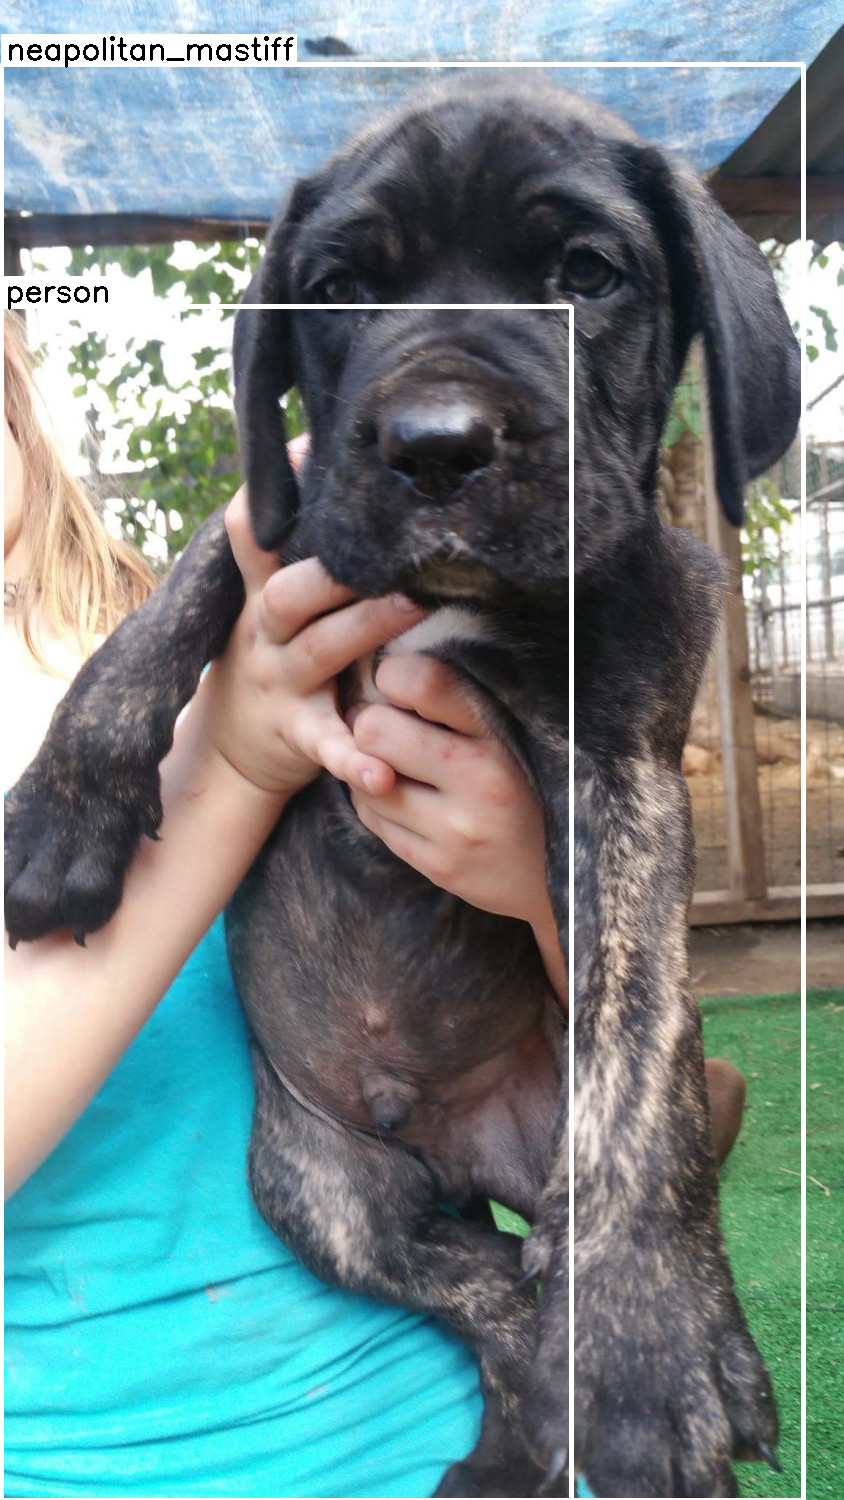

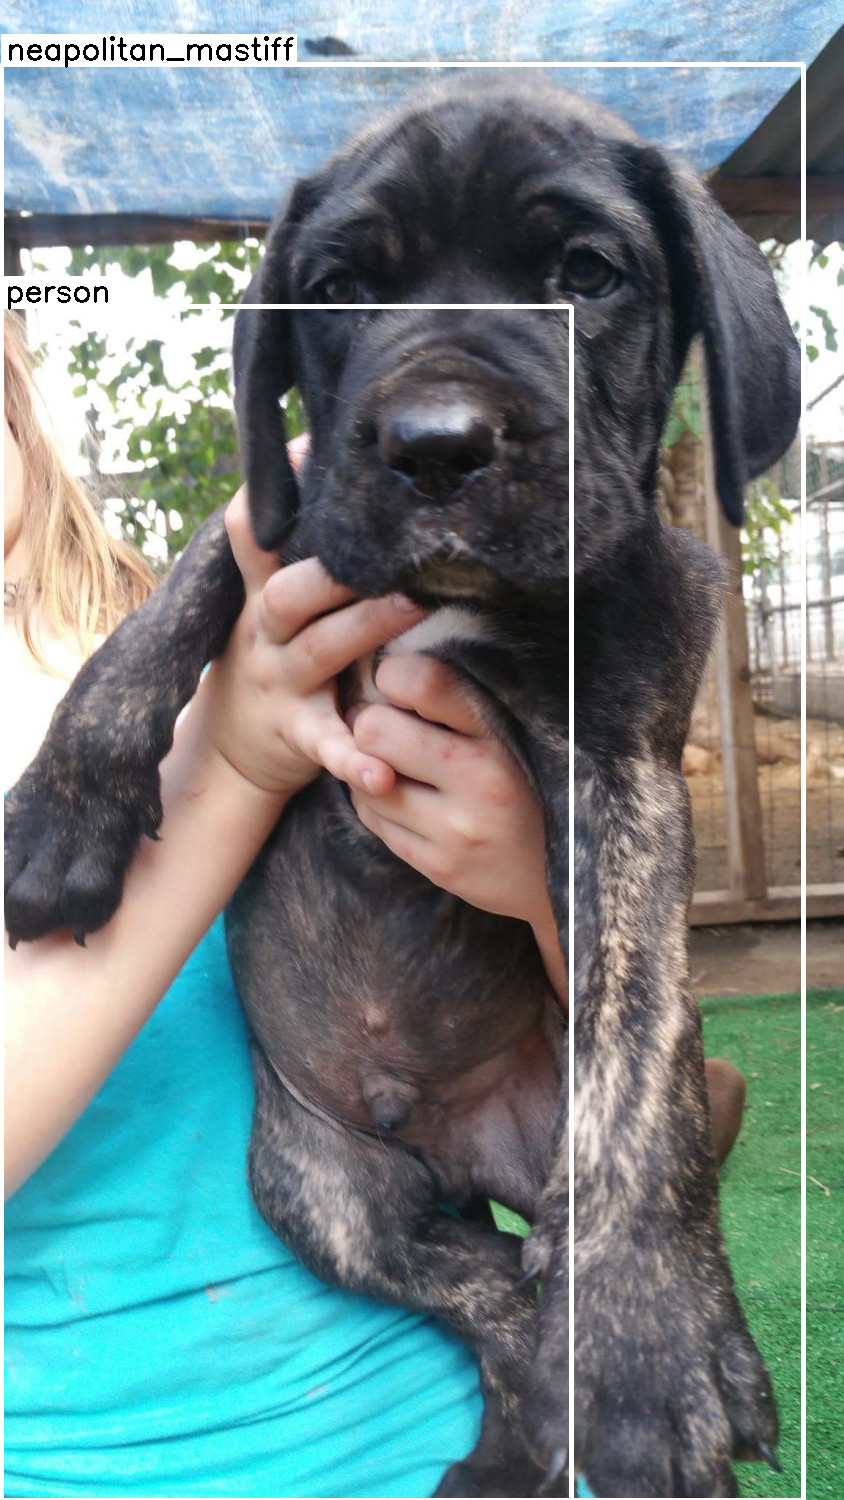

In [72]:
from IPython.display import display

display(
    dataset_train.df["img_filename"][0], dataset_train.visualize.ShowBoundingBoxes(0)
)
display(dataset_train.visualize.ShowBoundingBoxes("neapolitan_mastiff_0030.jpg"))

In [ ]:
dataset_train.export.ExportToVoc(
    output_path="../data/split_yolo/labels/voc_annotations"
)

## Setup

KerasCV is an extension of Keras for computer vision tasks. In this example, we'll see how to train a YOLOV8 object detection model using KerasCV.

KerasCV includes pre-trained models for popular computer vision datasets, such as ImageNet, COCO, and Pascal VOC, which can be used for transfer learning. KerasCV also provides a range of visualization tools for inspecting the intermediate representations learned by the model and for visualizing the results of object detection and segmentation tasks.

If you're interested in learning about object detection using KerasCV, I highly suggest taking a look at the guide created by lukewood. This resource, available at [Object Detection With KerasCV](https://keras.io/guides/keras_cv/object_detection_keras_cv/#object-detection-introduction), provides a comprehensive overview of the fundamental concepts and techniques required for building object detection models with KerasCV.

In [1]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

## Load Data

For this guide, we will be utilizing my dataset.

To simplify the task at hand and focus our efforts, we will be working with my number of object classes. Specifically, we will be considering 15 dog breed classes, other_dog_breed, person and human_face as primary classes for detection and classification. These classes represent my dataset.

By narrowing down the dataset to these specific classes, we can concentrate on building a robust object detection model that can accurately identify and classify these important objects.

The TensorFlow Datasets library provides a convenient way to download and use various datasets, including the object detection dataset. This can be a great option for those who want to quickly start working with the data without having to manually download and preprocess it.

You can view various object detection datasets here [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview#object_detection)

However, in this code example, we will demonstrate how to load the dataset from scratch using TensorFlow's [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) pipeline. This approach provides more flexibility and allows you to customize the preprocessing steps as needed.

Loading custom datasets that are not available in the TensorFlow Datasets library is one of the main advantages of using the [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) pipeline. This approach allows you to create a custom data preprocessing pipeline tailored to the specific needs and requirements of your dataset.

In [ ]:
# from pathlib import Path

# def check_image_formats(directory: str) -> None:
#     """
#     Check image formats in directory using PIL, excluding json and xml files.
    
#     Args:
#         directory: Path to directory containing images
#     """
#     img_count = 0
#     non_jpeg_count = 0
    
#     for img_path in Path(directory).rglob("*"):
#         # Skip json and xml files
#         if img_path.suffix.lower() in [".json", ".xml", ".txt"]:
#             continue
            
#         # Skip directories
#         if img_path.is_dir():
#             continue
            
#         try:
#             with Image.open(img_path) as img:
#                 img_count += 1
#                 if img.format != "JPEG":
#                     print(f"Non-JPEG image found: {img_path} (Format: {img.format})")
#                     non_jpeg_count += 1
#         except Exception as e:
#             print(f"Error reading file: {img_path}, Error: {e}")

#     print(f"\nTotal images checked: {img_count}")
#     print(f"Non-JPEG images found: {non_jpeg_count}")

# print("Checking image directory...")
# check_image_formats(path_images)


Checking image directory...
Non-JPEG image found: ../data/renamed_dub_removed/neapolitan_mastiff_0086.jpg (Format: WEBP)
Non-JPEG image found: ../data/renamed_dub_removed/mastiff_0020.jpg (Format: WEBP)
Non-JPEG image found: ../data/renamed_dub_removed/dogue_de_bordeaux_0012.jpg (Format: WEBP)
Error reading file: ../data/renamed_dub_removed/labels/.DS_Store, Error: cannot identify image file '../data/renamed_dub_removed/labels/.DS_Store'
Error reading file: ../data/renamed_dub_removed/labels/yolo_txt_annotations/.DS_Store, Error: cannot identify image file '../data/renamed_dub_removed/labels/yolo_txt_annotations/.DS_Store'

Total images checked: 1753
Non-JPEG images found: 3


Fixed files by opening in `Preview.app` and exporting as `.jpg` file

## Hyperparameters

In [2]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 1
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

A dictionary is created to map each class name to a unique numerical identifier. This mapping is used to encode and decode the class labels during training and inference in object detection tasks.

In [3]:
class_ids = [
    'dogue_de_bordeaux',
    'staffordshire_bullterrier',
    'dogo_argentino',
    'other_dog_breed',
    'cau_ovcharka',
    'person',
    'human_face',
    'am_pit_bull_terrier',
    'fila_brasileiro',
    'bull_terrier',
    'kangal',
    'neapolitan_mastiff',
    'rottweiler',
    'bull_mastiff',
    'mastin_espanol',
    'tosa_inu',
    'am_staffordshire_terrier',
    'mastiff'
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../data/renamed_dub_removed"
path_annot = "../data/renamed_dub_removed/labels/voc_annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

The function below reads the XML file and finds the image name and path, and then iterates over each object in the XML file to extract the bounding box coordinates and class labels for each object.

The function returns three values: the image path, a list of bounding boxes (each represented as a list of four floats: xmin, ymin, xmax, ymax), and a list of class IDs (represented as integers) corresponding to each bounding box. The class IDs are obtained by mapping the class labels to integer values using a dictionary called `class_mapping`.

In [4]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/1752 [00:00<?, ?it/s]

Here we are using [tf.ragged.constant](https://www.tensorflow.org/api_docs/python/tf/ragged/constant) to create ragged tensors from the `bbox` and `classes` lists. A ragged tensor is a type of tensor that can handle varying lengths of data along one or more dimensions. This is useful when dealing with data that has variable-length sequences, such as text or time series data.

In [5]:
classes[:10]

[[7], [7], [7], [7], [7], [7], [7], [7], [7], [7, 7, 7, 7, 7]]

In [6]:
bbox[:10]

[[[139.0, 59.0, 1296.0, 1346.0]],
 [[71.0, 18.0, 1505.0, 1199.0]],
 [[224.0, 133.0, 1711.0, 1272.0]],
 [[0.0, 169.0, 1360.0, 1717.0]],
 [[119.0, 29.0, 959.0, 899.0]],
 [[202.0, 40.0, 1060.0, 1248.0]],
 [[78.0, 30.0, 934.0, 960.0]],
 [[143.0, 65.0, 1099.0, 1402.0]],
 [[141.0, 130.0, 1140.0, 1416.0]],
 [[61.0, 631.0, 432.0, 1076.0],
  [502.0, 816.0, 855.0, 1079.0],
  [826.0, 579.0, 1080.0, 1080.0],
  [1.0, 48.0, 842.0, 1012.0],
  [1.0, 136.0, 1047.0, 755.0]]]

In this case, the `bbox` and `classes` lists have different lengths for each image, depending on the number of objects in the image and the corresponding bounding boxes and classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/ragged/constant) using the `from_tensor_slices` method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [7]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2025-01-21 23:08:08.268420: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-21 23:08:08.268484: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-21 23:08:08.268492: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-21 23:08:08.268522: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-21 23:08:08.268566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

Let's see about data loading and bounding box formatting to get things going. Bounding boxes in KerasCV have a predetermined format. To do this, you must bundle your bounding boxes into a dictionary that complies with the requirements listed below:

```python
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

The dictionary has two keys, `'boxes'` and `'classes'`, each of which maps to a TensorFlow RaggedTensor or Tensor object. The `'boxes'` Tensor has a shape of `[batch, num_boxes, 4]`, where batch is the number of images in the batch and num_boxes is the maximum number of bounding boxes in any image. The 4 represents the four values needed to define a bounding box: xmin, ymin, xmax, ymax.

The `'classes'` Tensor has a shape of `[batch, num_boxes]`, where each element represents the class label for the corresponding bounding box in the `'boxes'` Tensor. The num_boxes dimension may be ragged, which means that the number of boxes may vary across images in the batch.

Final dict should be:

```python
{"images": images, "bounding_boxes": bounding_boxes}
```

In [9]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Here we create a layer that resizes images to 640x640 pixels, while maintaining the original aspect ratio. The bounding boxes associated with the image are specified in the `xyxy` format. If necessary, the resized image will be padded with zeros to maintain the original aspect ratio.

Bounding Box Formats supported by KerasCV:

1. CENTER_XYWH
2. XYWH
3. XYXY
4. REL_XYXY
5. REL_XYWH
6. YXYX
7. REL_YXYX

You can read more about KerasCV bounding box formats in [docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Furthermore, it is possible to perform format conversion between any two pairs:

```python
boxes = keras_cv.bounding_box.convert_format(
        bounding_box,
        images=image,
        source="xyxy",  # Original Format
        target="xywh",  # Target Format (to which we want to convert)
    )
```

## Data Augmentation

One of the most challenging tasks when constructing object detection pipelines is data augmentation. It involves applying various transformations to the input images to increase the diversity of the training data and improve the model's ability to generalize. However, when working with object detection tasks, it becomes even more complex as these transformations need to be aware of the underlying bounding boxes and update them accordingly.

KerasCV provides native support for bounding box augmentation. KerasCV offers an extensive collection of data augmentation layers specifically designed to handle bounding boxes. These layers intelligently adjust the bounding box coordinates as the image is transformed, ensuring that the bounding boxes remain accurate and aligned with the augmented images.

By leveraging KerasCV's capabilities, developers can conveniently integrate bounding box-friendly data augmentation into their object detection pipelines. By performing on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and efficient, enabling better training and more accurate object detection results.

In [10]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [11]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [12]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

2025-01-21 23:09:35.488507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-21 23:09:36.647902: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{function_node jittered_resize_1_1_map_while_body_2494}}{{node jittered_resize_1_1/map/while/map/while}}]]


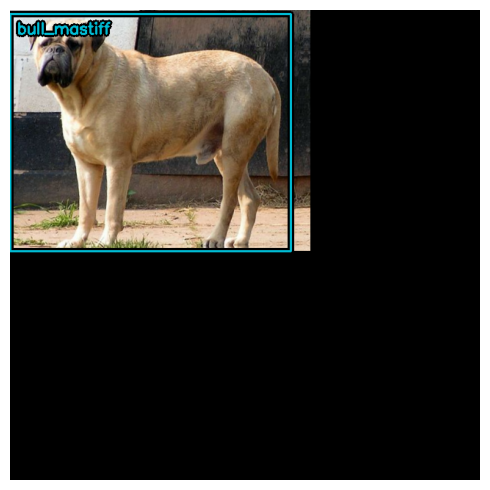

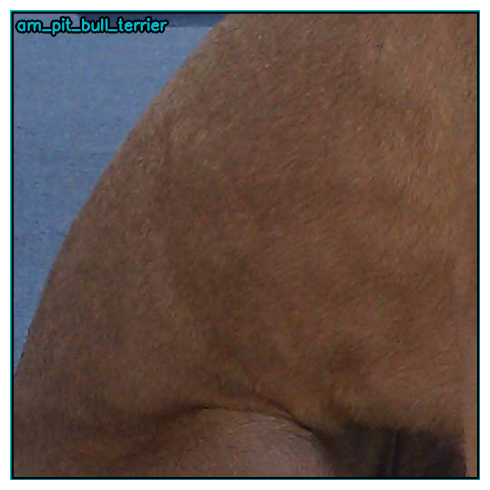

In [13]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.

In [14]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

YOLOv8 is a cutting-edge YOLO model that is used for a variety of computer vision tasks, such as object detection, image classification, and instance segmentation. Ultralytics, the creators of YOLOv5, also developed YOLOv8, which incorporates many improvements and changes in architecture and developer experience compared to its predecessor. YOLOv8 is the latest state-of-the-art model that is highly regarded in the industry.

Below table compares the performance metrics of five different YOLOv8 models with different sizes (measured in pixels): YOLOv8n, YOLOv8s, YOLOv8m, YOLOv8l, and YOLOv8x. The metrics include mean average precision (mAP) values at different intersection-over-union (IoU) thresholds for validation data, inference speed on CPU with ONNX format and A100 TensorRT, number of parameters, and number of floating-point operations (FLOPs) (both in millions and billions, respectively). As the size of the model increases, the mAP, parameters, and FLOPs generally increase while the speed decreases. YOLOv8x has the highest mAP, parameters, and FLOPs but also the slowest inference speed, while YOLOv8n has the smallest size, fastest inference speed, and lowest mAP, parameters, and FLOPs.

| Model | size (pixels) | mAPval 50-95 | Speed CPU ONNX (ms) | Speed A100 TensorRT (ms) | params (M) | FLOPs (B) |
| --- | --- | --- | --- | --- | --- | --- |
| YOLOv8n | 640 | 37.3 | 80.4 | 0.99 | 3.2 | 8.7 |
| YOLOv8s | 640 | 44.9 | 128.4 | 1.20 | 11.2 | 28.6 |
| YOLOv8m | 640 | 50.2 | 234.7 | 1.83 | 25.9 | 78.9 |
| YOLOv8l | 640 | 52.9 | 375.2 | 2.39 | 43.7 | 165.2 |
| YOLOv8x | 640 | 53.9 | 479.1 | 3.53 | 68.2 | 257.8 |

You can read more about YOLOV8 and its architecture in this [RoboFlow Blog](https://blog.roboflow.com/whats-new-in-yolov8/)

First we will create a instance of backbone which will be used by our yolov8 detector class.

YOLOV8 Backbones available in KerasCV:

1. Without Weights:
   1.   yolo_v8_xs_backbone
   2.   yolo_v8_s_backbone
   3.   yolo_v8_m_backbone
   4.   yolo_v8_l_backbone
   5.   yolo_v8_xl_backbone
2. With Pre-trained coco weight:
   1.   yolo_v8_xs_backbone_coco
   2.   yolo_v8_s_backbone_coco
   3.   yolo_v8_m_backbone_coco
   4.   yolo_v8_l_backbone_coco
   5.   yolo_v8_xl_backbone_coco

In [15]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature extractor as the `backbone` argument, a `num_classes` argument that specifies the number of object classes to detect based on the size of the `class_mapping` list, a `bounding_box_format` argument that informs the model of the format of the bbox in the dataset, and a finally, the feature pyramid network (FPN) depth is specified by the `fpn_depth` argument.

It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to KerasCV.

In [16]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

## Compile the Model

Loss used for YOLOV8

1. Classification Loss: This loss function calculates the discrepancy between anticipated class probabilities and actual class probabilities. In this instance, `binary_crossentropy`, a prominent solution for binary classification issues, is Utilized. We Utilized binary crossentropy since each thing that is identified is either classed as belonging to or not belonging to a certain object class (such as a person, a car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU) metric is used, which not only measures the overlap between predicted and ground truth bounding boxes but also considers the difference in aspect ratio, center distance, and box size. Together, these loss functions help optimize the model for object detection by minimizing the difference between the predicted and ground truth class probabilities and bounding boxes.


In [17]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
#    clipnorm=1.0,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the Map(Mean Average Precision) score, Recall and Precision. We also save our model when the mAP score improves.

In [18]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [20]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(2, 640, 640, 3), dtype=tf.float32, name=None), {'classes': RaggedTensorSpec(TensorShape([2, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([2, None, 4]), tf.float32, 1, tf.int64)})>

## Train the Model

In [19]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/2


/opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


: 

## Load Model for inspection

In [7]:
import torchvision
from torchvision import transforms as T


In [22]:
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

/opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/helloDogBreed/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /Users/tillmeineke/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:21<00:00, 6.69MB/s] 


In [23]:
model.eval()

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [28]:
ig = Image.open("../data/raw/143_dog_breeds/bull_terrier/Image_100.JPG")

In [29]:
transform = T.ToTensor()
img = transform(ig)

In [30]:
with torch.no_grad():
    prediction = model([img])

In [32]:
prediction

[{'boxes': tensor([[1.3343e+01, 3.8110e+00, 4.1904e+02, 3.2028e+02],
          [1.2582e+01, 0.0000e+00, 4.2223e+02, 3.2378e+02],
          [2.3101e+02, 0.0000e+00, 3.8221e+02, 5.4556e+01],
          [2.6924e+02, 1.4317e+02, 3.2277e+02, 1.8152e+02],
          [2.7222e+02, 1.5367e+02, 2.9613e+02, 1.7300e+02],
          [2.9227e+02, 1.3697e+02, 3.3680e+02, 1.8014e+02],
          [3.1990e+02, 0.0000e+00, 3.7721e+02, 4.5855e+01],
          [2.8552e+02, 1.5603e+02, 3.0297e+02, 1.7224e+02],
          [3.0318e+02, 0.0000e+00, 3.4836e+02, 4.6430e+01],
          [2.5980e+02, 1.5238e+02, 3.0527e+02, 1.8938e+02],
          [2.8394e+02, 1.4727e+02, 3.0438e+02, 1.6488e+02],
          [2.2789e+02, 0.0000e+00, 2.8792e+02, 5.1474e+01],
          [2.1617e+02, 0.0000e+00, 3.1443e+02, 1.0101e+02],
          [2.6220e+02, 0.0000e+00, 3.6315e+02, 1.0493e+02],
          [2.7507e+02, 0.0000e+00, 3.2826e+02, 4.4219e+01],
          [2.7581e+02, 1.6565e+02, 2.9429e+02, 1.8070e+02],
          [2.3164e+02, 1.7053e+

In [33]:
type(prediction)

list

In [37]:
type(prediction[0])

dict

In [35]:
prediction[0].keys()

dict_keys(['boxes', 'scores', 'labels'])

In [39]:
bboxes, scores, labels = (
    prediction[0]["boxes"],
    prediction[0]["scores"],
    prediction[0]["labels"],
)

In [41]:
scores

tensor([0.9244, 0.1176, 0.0655, 0.0653, 0.0536, 0.0532, 0.0529, 0.0513, 0.0511,
        0.0503, 0.0503, 0.0493, 0.0478, 0.0473, 0.0452, 0.0448, 0.0443, 0.0440,
        0.0432, 0.0431, 0.0426, 0.0423, 0.0416, 0.0414, 0.0408, 0.0403, 0.0383,
        0.0380, 0.0380, 0.0372, 0.0364, 0.0350, 0.0349, 0.0348, 0.0348, 0.0341,
        0.0337, 0.0327, 0.0325, 0.0325, 0.0317, 0.0316, 0.0315, 0.0313, 0.0309,
        0.0309, 0.0308, 0.0300, 0.0297, 0.0295, 0.0290, 0.0288, 0.0284, 0.0281,
        0.0277, 0.0276, 0.0276, 0.0271, 0.0270, 0.0269, 0.0269, 0.0267, 0.0265,
        0.0264, 0.0262, 0.0262, 0.0260, 0.0253, 0.0249, 0.0249, 0.0248, 0.0244,
        0.0243, 0.0238, 0.0232, 0.0231, 0.0225, 0.0224, 0.0224, 0.0223, 0.0220,
        0.0218, 0.0217, 0.0214, 0.0214, 0.0212, 0.0212, 0.0210, 0.0207, 0.0206,
        0.0203, 0.0200, 0.0200, 0.0199, 0.0199, 0.0196, 0.0194, 0.0191, 0.0191,
        0.0190, 0.0190, 0.0189, 0.0189, 0.0188, 0.0188, 0.0183, 0.0180, 0.0173,
        0.0173, 0.0172, 0.0171, 0.0169, 

In [42]:
labels

tensor([18, 19,  1, 56, 56, 56,  1, 56,  1, 56, 56,  1,  1,  1,  1, 56, 56,  1,
        56, 56,  1, 56, 56,  1, 56, 56, 56,  1,  1, 56,  1, 56, 56, 56,  1, 56,
         1, 16, 56, 18, 56, 56, 56,  1, 56, 56, 24,  1, 56,  1, 56, 56, 18,  1,
        56,  1, 56, 56, 18,  1,  1,  1, 56, 56, 16, 56,  1,  1, 18,  1, 18,  1,
         1,  1, 56, 56, 56, 56, 24, 56, 24, 56, 24, 56, 56, 56,  1, 56, 56,  1,
        56, 56, 20, 16,  1,  1,  1, 20, 56, 18, 56,  1, 56, 56, 56, 56,  1, 56,
        18, 56, 56, 56, 56, 20, 18, 24, 56, 20, 24,  1,  1, 20, 18,  1,  1, 18,
        56, 56, 20, 56, 56, 20,  1,  1,  1, 20, 56, 56, 56, 20,  1,  1, 56, 57,
        24,  1, 20, 24,  1, 56, 56, 20,  1, 20,  1, 16, 64, 18, 18, 20, 34, 56,
         1,  1,  1, 18,  1, 18,  1, 20, 56, 56, 56, 20, 20, 20, 56, 20, 56, 18,
        20, 48, 56, 16, 56,  1, 18, 56, 56, 49,  1, 24, 56, 20,  1, 56,  1, 18,
         1, 16])

In [44]:
labels

torch.Size([200])